Training Data Shape: (25192, 42)
Test Data Shape: (22544, 41)
Categorical Columns: ['protocol_type', 'service', 'flag', 'class']


C:\Users\billa\AppData\Local\Temp\ipykernel_26660\3235479288.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
C:\Users\billa\AppData\Local\Temp\ipykernel_26660\3235479288.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co


Random Forest Performance:
              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      2365
      normal       0.99      1.00      0.99      2674

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039


SVM Performance:
              precision    recall  f1-score   support

     anomaly       0.98      0.96      0.97      2365
      normal       0.96      0.99      0.98      2674

    accuracy                           0.97      5039
   macro avg       0.97      0.97      0.97      5039
weighted avg       0.97      0.97      0.97      5039


KNN Performance:
              precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      2365
      normal       0.99      0.99      0.99      2674

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted a

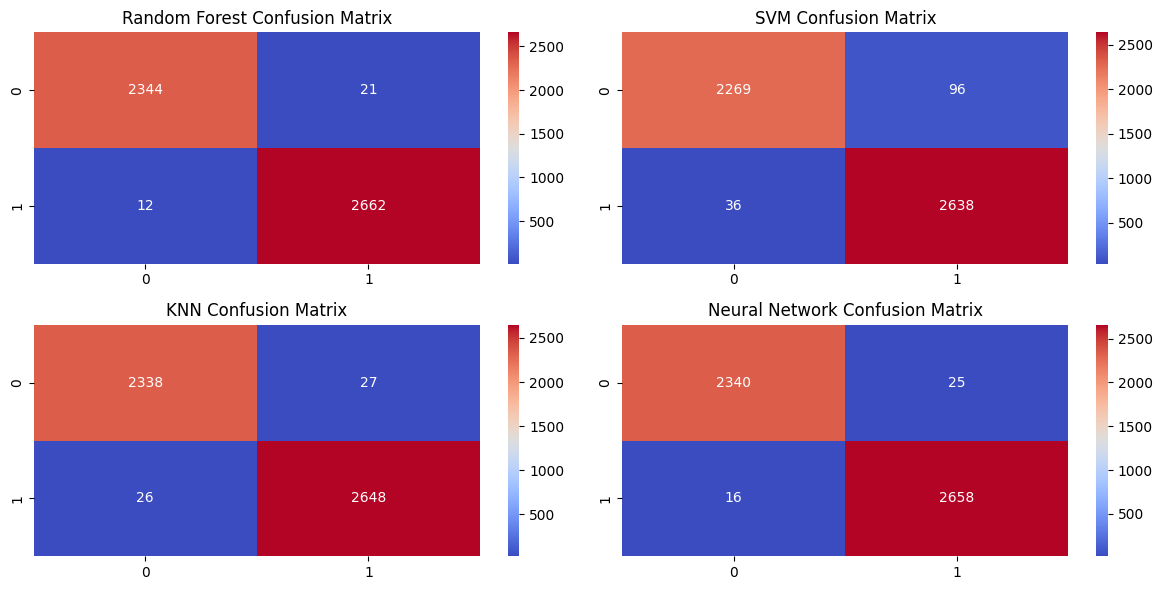

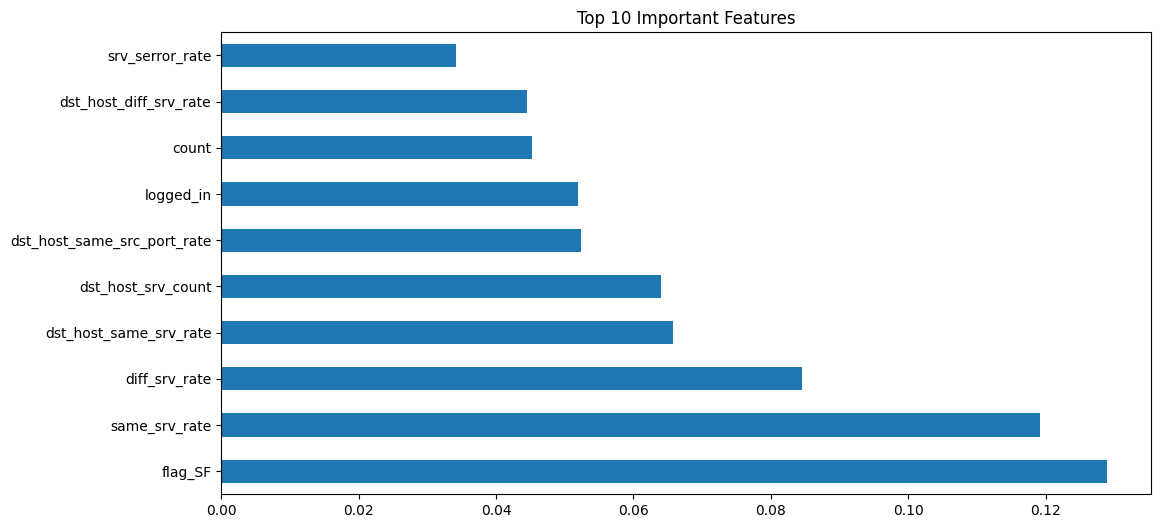

Predictions saved as 'Predicted_Test_Results.csv'.


In [125]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Load Datasets
train_path = "C:\\New Downloads\\Task\\Dataset\\Train_data.csv"
test_path = "C:\\New Downloads\\Task\\Dataset\\Test_data.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display basic info
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

# Identify Categorical Columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

# Handle Missing Values (Fill Numeric Columns with Median)
for col in train_df.select_dtypes(include=['float64', 'int64']).columns:
    train_df[col].fillna(train_df[col].median(), inplace=True)

for col in test_df.select_dtypes(include=['float64', 'int64']).columns:
    test_df[col].fillna(test_df[col].median(), inplace=True)

# Ensure 'class' is NOT in categorical columns
cat = [col for col in categorical_cols if col != 'class']

# Apply One-Hot Encoding
train_df = pd.get_dummies(train_df, columns=cat, drop_first=True)
test_df = pd.get_dummies(test_df, columns=cat, drop_first=True)

# Align test_df with train_df to match features
test_df = test_df.reindex(columns=train_df.columns.drop('class'), fill_value=0)

# Identify Features and Target
X = train_df.drop(columns=['class'])
y = train_df['class']

# Feature Selection: Select Top 50 Features
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X_test_selected = selector.transform(test_df)

# Standardize Features (Normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Split Data (Train 80%, Validation 20%)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Multiple Models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear')
knn_model = KNeighborsClassifier(n_neighbors=5)
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', max_iter=500, random_state=42)

models = {
    "Random Forest": rf_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "Neural Network": mlp_model
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)

# Predictions
predictions = {name: model.predict(X_val) for name, model in models.items()}

# Model Evaluation
for name, preds in predictions.items():
    print(f"\n{name} Performance:")
    print(classification_report(y_val, preds))

# Confusion Matrix Visualization
plt.figure(figsize=(12, 6))
for i, (name, preds) in enumerate(predictions.items(), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(confusion_matrix(y_val, preds), annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

# Feature Importance (Random Forest)
feature_importances = pd.Series(rf_model.feature_importances_, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importances[:10].plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

# Make Final Predictions on Test Data
final_predictions = rf_model.predict(X_test_scaled)

# Convert Predictions to DataFrame
test_results = pd.DataFrame(final_predictions, columns=['Predicted_Class'])
test_results.to_csv("C:\\New Downloads\\Task\\Predicted_Test_Results.csv", index=False)

print("Predictions saved as 'Predicted_Test_Results.csv'.")
